In [1]:
train_csv_path = '../input/toy-dataset-for-regression-and-uq/Data9_Train.csv'
test_csv_path = '../input/toy-dataset-for-regression-and-uq/Data9_Test.csv'
val_csv_path = '../input/toy-dataset-for-regression-and-uq/Data9_Val.csv'



import pandas as pd
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
train_df.head()

,Input1,Output
0,-1.000,-0.198589
1,-0.991,-0.108559
2,-0.982,-0.027084
3,-0.973,0.023096
4,-0.964,0.231983


In [2]:
input_=[]
output_=[]
for row in train_df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])
    
i_val=[]
o_val=[]
for row in val_df.iloc:
    i_val.append((row[0:len(row)-1]).astype(float))
    o_val.append(row[-1])
    
num_input = len(row)-1;
print(num_input)

####################################################
#
# This code is written with the help of the demo:
# https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379
#
####################################################
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio


torch.manual_seed(1)    # reproducible

x = torch.tensor(input_).float()  
y = torch.tensor(output_).float()   
new_shape = (len(y), 1)
y = y.view(new_shape)


i_val = torch.tensor(i_val).float()  
o_val = torch.tensor(o_val).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)



max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print(range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

1
tensor(1.0430) tensor(-1.0908) tensor([0.9910]) tensor([-1.])
tensor([1.9910]) tensor(2.1338)


In [3]:
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
 
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

# use the same net as before      
net = Net(n_feature=num_input, n_hidden=1000, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss


minimum_train_loss = 1e5
minimum_val_loss = 1e5
EPOCH = 2000

# start training
for epoch in range(EPOCH):
  
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if loss<minimum_train_loss:
        minimum_train_loss =loss
        net_opt = net
    
    if epoch%200 == 199:
      prediction = net_opt(i_val)
      loss_val = loss_func(prediction, o_val)
      if loss_val<minimum_val_loss:
        minimum_val_loss = loss_val
        net_opt_val = net_opt
      print ("Epoch [{}/{}], Loss: {:.4f}, Minimum Loss {:.6f}, Val Loss {:.6f}  "  .format(epoch+1, EPOCH, loss, minimum_train_loss, minimum_val_loss))

Net(
  (hidden): Linear(in_features=1, out_features=1000, bias=True)
  (hidden2): Linear(in_features=1000, out_features=1000, bias=True)
  (predict): Linear(in_features=1000, out_features=1, bias=True)
)
Epoch [200/2000], Loss: 0.0746, Minimum Loss 0.074553, Val Loss 0.094784  
Epoch [400/2000], Loss: 0.0671, Minimum Loss 0.067136, Val Loss 0.094784  
Epoch [600/2000], Loss: 0.0638, Minimum Loss 0.063785, Val Loss 0.094784  
Epoch [800/2000], Loss: 0.0592, Minimum Loss 0.059179, Val Loss 0.091049  
Epoch [1000/2000], Loss: 0.0509, Minimum Loss 0.050910, Val Loss 0.080026  
Epoch [1200/2000], Loss: 0.0370, Minimum Loss 0.037000, Val Loss 0.058331  
Epoch [1400/2000], Loss: 0.0229, Minimum Loss 0.022934, Val Loss 0.033489  
Epoch [1600/2000], Loss: 0.0144, Minimum Loss 0.014415, Val Loss 0.018661  
Epoch [1800/2000], Loss: 0.0084, Minimum Loss 0.008412, Val Loss 0.010194  
Epoch [2000/2000], Loss: 0.0061, Minimum Loss 0.004988, Val Loss 0.006157  


In [4]:
test_df = pd.read_csv(test_csv_path)

i_test=[]
o_test=[]
for row in val_df.iloc:
    i_test.append((row[0:len(row)-1]).astype(float))
    o_test.append(row[-1])


   
i_test, o_test = Variable(torch.tensor(i_test)).float(), Variable(torch.tensor(o_test).float())
new_shape = (len(o_test), 1)
o_test = o_test.view(new_shape)

    #Normalizing
i_test = (i_test - min_x.values)/range_x
o_test = (o_test - min_y)/range_y

prediction = net_opt_val(i_test)
loss_test = loss_func(prediction, o_test)

print("Normalized Test Loss",loss_test.detach().numpy())

loss_test = loss_test*range_y*range_y # As the loss function returns MSE

print("Test Loss",loss_test.detach().numpy())



Normalized Test Loss 0.0061570406
Test Loss 0.0280336


In [5]:
import math
standard_deviation = math.sqrt(minimum_val_loss)
z_95 = 1.96*standard_deviation
LB = prediction.detach().numpy() - z_95
UB = prediction.detach().numpy() + z_95
o_test = o_test.detach().numpy()


#Denormalization
i_test = i_test*range_x + min_x.values
o_test = o_test*range_y.detach().numpy() + min_y.detach().numpy()
LB = LB*range_y.detach().numpy() + min_y.detach().numpy()
UB = UB*range_y.detach().numpy() + min_y.detach().numpy()
prediction = prediction*range_y + min_y

PINAW: 0.30372913430724036   PINC: 0.96   PINAFD:  0.0010452568206627813


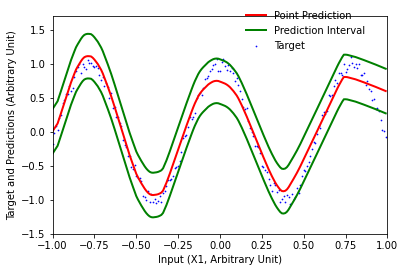

In [6]:

fig, (ax1) = plt.subplots(1, 1)

ax1.set(xlabel="Input (X1, Arbitrary Unit)", ylabel="Target and Predictions (Arbitrary Unit)" , ylim = (-1.5, 1.7), xlim = (-1,1))
plt.rcParams["figure.figsize"] = (6,5)

ax1.plot(i_test[:,0], prediction.detach().numpy(), color='r', linewidth=2, label='Point Prediction')
ax1.plot(i_test[:,0], LB, color='g', linewidth=2, label='Prediction Interval')
ax1.scatter(i_test[:,0], o_test, color='b',s=.5, label='Target')
ax1.plot(i_test[:,0], UB, linewidth=2, color='g')

leg = ax1.legend(frameon=False, loc='lower left', bbox_to_anchor=(0.55,0.8));

fig.show()




PINAW = np.sum(UB-LB)/len(UB)/(np.max(o_test)-np.min(o_test)) 
# here PINAW= 2*z_95


PINC = 0
PINAFD =0
for iter1 in range(len(UB)):
    if UB[iter1]>=o_test[iter1] and LB[iter1]<=o_test[iter1]:
        PINC = PINC+1
    else:
        PINAFD = PINAFD + np.min([np.abs(UB[iter1]-o_test[iter1]), np.abs(LB[iter1]<o_test[iter1])]) 
        # PINAFD distance from the nearest interval


if PINAFD>0:
    PINAFD = PINAFD/(len(UB) - PINC)/(np.max(o_test)-np.min(o_test))         

PINC = PINC/len(UB)

print("PINAW:",PINAW, "  PINC:", PINC, "  PINAFD: ", PINAFD) 
